# Carga de librerías y funciones

In [1]:
import joblib
import json
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
def get_filename(path):
    # Obtenemos el nombre del fichero
    filename = path.split("/")[-1].split(".")[0]
    return filename

def train_model(x, y, model, param_grid):
    # Modelos a probar
    model_dict = {
        "svr": LinearSVR(random_state=123),
        "decision_tree": DecisionTreeRegressor(random_state=123),
        "random_forest": RandomForestRegressor(random_state=123)
    }
    # Búsqueda de hiperparámetros
    model_trained = GridSearchCV(
        estimator = model_dict[model], 
        param_grid = param_grid, 
        n_jobs = -1, 
        cv = 5, 
        verbose = 2, 
        scoring = "neg_root_mean_squared_error",   
    )
    # Entrenamiento del modelo
    model_trained.fit(x, y)
    return model_trained

# Carga de datos

In [3]:
# Conjunto de datos a cargar
train_path = input()

# Obtenemos el nombre del fichero
filename = get_filename(train_path)

# Cargamos el conjunto de datos
train = pd.read_csv(train_path, sep=",")

# Obtenemos las variables categóricas del conjunto de datos
cat_cols = ["ID_FINCA", "ID_ZONA", "ID_ESTACION", "VARIEDAD", "MODO", "TIPO", "COLOR"]
cat_cols_train = [col for col in cat_cols if col in train.columns]

# Cambiamos a categóricas las variables que son categóricas
train[cat_cols_train] = train[cat_cols_train].astype('category')

# División de los datos en variables predictoras y variable objetivo
x_train = train[train.columns.drop(["PRODUCCION"])]
y_train = train.PRODUCCION

# Mostramos las primeras observaciones del conjunto de entrenamiento
x_train.head(5)

,ID_FINCA,ID_ZONA,ID_ESTACION,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,TemperatureLocalDayAvg,TemperatureLocalNighttimeAvg,WindSpeedLocalDayAvg
0,48626,302,13,32,2,0,1,0.977041,0.245761,0.396521,-0.197433
1,47921,302,13,32,2,0,1,1.625634,0.245761,0.396521,-0.197433
2,87611,602,14,81,1,0,1,0.806398,-0.859527,-0.492986,0.020158
3,12257,215,14,17,1,0,1,0.353163,-0.859527,-0.492986,0.020158
4,5696,919,14,59,1,0,1,1.657182,-0.859527,-0.492986,0.020158


In [4]:
# Cargamos la tabla de resultados o la creamos si no existe
try:
    results = pd.read_csv("results.txt", sep="\t")
except:
    results = pd.DataFrame(columns=["Model", "RMSE"])

In [5]:
# Carga de la media y desviación estándar para deshacer la normalización de la variable objetivo
if "log" in filename:
    mean, sd = pd.read_csv("mean_sd_log.txt").PRODUCCION
else:
    mean, sd = pd.read_csv("mean_sd.txt").PRODUCCION

# Entrenamiento

## LinearSVR

In [ ]:
# Identificador del modelo
model = "svr"

# Parámetros a probar
param_grid = {
    'C': [0.1, 1, 10, 20, 50, 100],
    'epsilon': [0.01, 0.1, 1, 10, 50, 100],
    'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"]
}

# Entrenamiento del modelo
svr = train_model(x_train, y_train, model, param_grid)

# Predicción del modelo sobre los datos de entrenamiento
y_pred = svr.predict(x_train)

# Deshacer la normalización
y_train_t = y_train * sd + mean
y_pred_t = y_pred * sd + mean

if "log" in filename:
    # Deshacer el logaritmo
    y_train_t = np.e ** y_train_t
    y_pred_t = np.e ** y_pred_t

# Cálculo del RMSE sobre los datos de entrenamiento
mse = mean_squared_error(y_train, y_pred)
rmse = math.sqrt(mse)

# Mostramos los resultados
print(f"\nRMSE: {rmse}\n")

# Guardamos los resultados
new_results = pd.DataFrame.from_dict({"Model": [f"{model}_{filename}"], "RMSE": [np.round(rmse, 3)]})
results = pd.concat([results, new_results])

# Guardamos los hiperparámetros del mejor modelo
with open(f"params_{model}_{filename}.json", "w") as outfile:
    json.dump(svr.best_params_, outfile)

## Decision Tree Regressor

In [ ]:
# Identificador del modelo
model = "decision_tree"

# Parámetros a probar
param_grid = {
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Entrenamiento del modelo
dt = train_model(x_train, y_train, model, param_grid)

# Predicción del modelo sobre los datos de entrenamiento
y_pred = dt.predict(x_train)

# Deshacer la normalización
y_train_t = y_train * sd + mean
y_pred_t = y_pred * sd + mean

if "log" in filename:
    # Deshacer el logaritmo
    y_train_t = np.e ** y_train_t
    y_pred_t = np.e ** y_pred_t

# Cálculo del RMSE sobre los datos de entrenamiento
mse = mean_squared_error(y_train, y_pred)
rmse = math.sqrt(mse)

# Mostramos los resultados
print(f"\nRMSE: {rmse}\n")

# Guardamos los resultados
new_results = pd.DataFrame.from_dict({"Model": [f"{model}_{filename}"], "RMSE": [np.round(rmse, 3)]})
results = pd.concat([results, new_results])

# Guardamos los hiperparámetros del mejor modelo
with open(f"params_{model}_{filename}.json", "w") as outfile:
    json.dump(dt.best_params_, outfile)

## Random Forest Regressor

In [ ]:
# Identificador del modelo
model = "random_forest"

# Parámetros a probar
param_grid = {
    'n_estimators': [10, 20, 50],
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Entrenamiento del modelo
rf = train_model(x_train, y_train, model, param_grid)

# Predicción del modelo sobre los datos de entrenamiento
y_pred = rf.predict(x_train)

# Deshacer la normalización
y_train_t = y_train * sd + mean
y_pred_t = y_pred * sd + mean

if "log" in filename:
    # Deshacer el logaritmo
    y_train_t = np.e ** y_train_t
    y_pred_t = np.e ** y_pred_t

# Cálculo del RMSE sobre los datos de entrenamiento
mse = mean_squared_error(y_train, y_pred)
rmse = math.sqrt(mse)

# Mostramos los resultados
print(f"\nRMSE: {rmse}\n")

# Guardamos los resultados
new_results = pd.DataFrame.from_dict({"Model": [f"{model}_{filename}"], "RMSE": [np.round(rmse, 3)]})
results = pd.concat([results, new_results])

# Guardamos los hiperparámetros del mejor modelo
with open(f"params_{model}_{filename}.json", "w") as outfile:
    json.dump(rf.best_params_, outfile)

# Resultados

In [6]:
# Ordenamos los resultados de menor a mayor RMSE
results = results.sort_values("RMSE").reset_index(inplace=False, drop=True)
# Guardamos los resultados en un txt
results.to_csv("results.txt", sep="\t", index=False)
# Mostramos los resultados
results

,Model,RMSE
0,random_forest_train_train_norm_tempwind,2857.655
1,random_forest_train_train_norm_temp,2905.609
2,random_forest_train_train_temp,2914.383
3,random_forest_train_train_norm_tempwindSINTIPO,2951.461
4,random_forest_train_train_norm_tempwindhum,2958.166
5,random_forest_dataset_final,2982.987
6,random_forest_trainetometeo_train_norm_simple,3071.922
7,random_forest_trainetometeo_train_norm_simple_...,3078.570
8,random_forest_trainetometeo_train_norm_simple_...,3096.070
9,random_forest_trainetometeo_train_log_norm_simple,3735.005


# Criterios aplicados para la selección del modelo

In [7]:
# Tipo de modelo
model = "random_forest"

# Cargamos los parámetros guardados del mejor modelo
with open(f"params_{model}_{filename}.json", "r") as f:
    params = json.load(f)

# Instanciamos el modelo Random Forest Regressor
regressor = RandomForestRegressor(**params, random_state=123)

# Entrenamos el modelo
regressor.fit(x_train, y_train)

# Guardamos el modelo en un fichero joblib
joblib.dump(regressor, f"{model}_{filename}.joblib")

['random_forest_train_train_norm_tempwind.joblib']

In [8]:
# Ordena la importancia de las variables de mayor a menor
indices = np.argsort(regressor.feature_importances_)[::-1]

# Muestra la importancia de las variables
for f in range(x_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, pd.Series(x_train.columns).iloc[indices].reset_index(inplace=False, drop=True)[f], 
                           regressor.feature_importances_[indices[f]]))

1. SUPERFICIE (0.576766)
2. VARIEDAD (0.090024)
3. ID_FINCA (0.078370)
4. WindSpeedLocalDayAvg (0.058552)
5. ID_ZONA (0.041501)
6. TemperatureLocalNighttimeAvg (0.039951)
7. MODO (0.039357)
8. TemperatureLocalDayAvg (0.036522)
9. ID_ESTACION (0.032084)
10. COLOR (0.005723)
11. TIPO (0.001150)


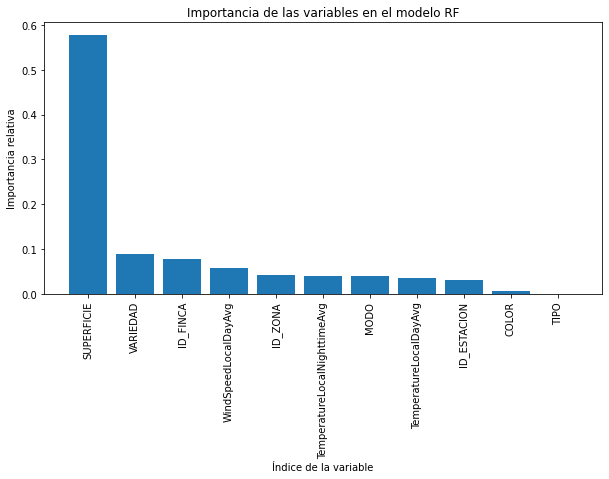

In [9]:
# Visualizar la importancia de las variables en un gráfico de barras
plt.figure(figsize=(10,5))
plt.title("Importancia de las variables en el modelo RF")
plt.bar(range(x_train.shape[1]), regressor.feature_importances_[indices])
plt.xticks(range(x_train.shape[1]), pd.Series(x_train.columns).iloc[indices], rotation=90)
plt.xlabel("Índice de la variable")
plt.ylabel("Importancia relativa")
plt.show()

# Modelos locales haciendo clusterización con k-Means y PCA

Tras visualizar los datos de las dos componentes principales de la PCA, se observa que los datos están agrupados en 2 clusters. Se realiza una agrupación de dichos clusters utilizando k-Means y se entrenan modelos locales para ambos clusters. Puesto que los mejores resultados obtenidos han dicho con los datos que contienen las variables de temperatura y velocidad del viento, se entrenan dos Random Forest a cada una de las agrupaciones.

In [35]:
pca_train_path = input() # data_pruebas/trainetometeo_train_norm_simple.txt
best_df_path = input() # data_pruebas/trainetometeo_train_log_norm_corr2.txt
pca_test_path = input() # data_pruebas/trainetometeo_test_norm_simple.txt
filename = get_filename(pca_train_path)

df = pd.read_csv(pca_train_path, sep=",")
best_df = pd.read_csv(pca_train_path, sep=",")
pca_test_df = pd.read_csv(pca_test_path, sep=",")

df_train = df.iloc[:,0:9]
df_meteor = df.iloc[:,10:30]

y = df['PRODUCCION']

[0.41481877 0.31254788 0.16474754 0.10788582]


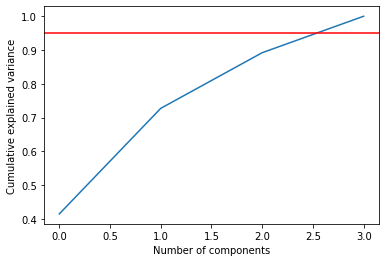

In [36]:
pca = PCA()
fit = pca.fit_transform(df_meteor)
print(pca.explained_variance_ratio_)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

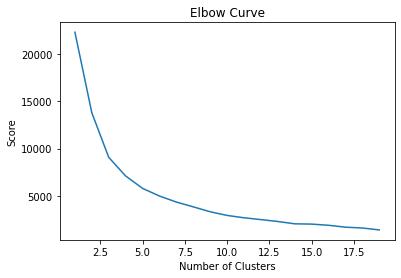

In [37]:
pca = PCA(n_components=3)
fit = pca.fit_transform(df_meteor)

Nc = range(1, 20)
score = []

for k in Nc:
    # Bucle de llamada al método fit()
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    km.fit(fit)
    score.append(km.inertia_)
        
# Este código visualiza la curva
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [38]:
kmeans = KMeans(n_clusters=2) # introduce un valor de K
kmeans.fit(fit) # Introduce el dataset transformado y calcula el modelo
y_kmeans = kmeans.predict(fit) # etiquetas de pertenencia a un cluster

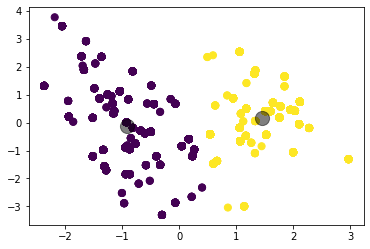

In [39]:
#Hacemos un nuevo DataFrame con dos columnas, el nombre de la compañía y la etiqueta del cluster correspondiente.
#Imprimimos la lista
newframe_train=pd.DataFrame({"comp":y, "class":y_kmeans})  #He llamado 'companies' a la lista de compañías que has debido crear
                                                            #en la primera caja de código de este notebook

plt.scatter(fit[:, 0], fit[:, 1], c=y_kmeans, s=50, cmap='viridis') #He llamado 'dtnorm' al dataset  transformado por el PCA
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [40]:
newframe_train = newframe_train.sort_index()
best_df['CLASS'] = newframe_train['class']
best_df

train_class_0 = best_df[best_df['CLASS'] == 0]
y_class_0 = train_class_0.pop('PRODUCCION')

train_class_1 = best_df[(best_df['CLASS'] == 1)]
y_class_1 = train_class_1.pop('PRODUCCION')

print(train_class_0.shape, train_class_1.shape)

(3834, 14) (2428, 14)


In [42]:
test = pca_test_df.iloc[:,0:9]

test_meteor = pca_test_df.iloc[:,10:30]

pca_test = pca.transform(test_meteor)

y_kmeans = kmeans.predict(pca_test) #etiquetas de pertenencia a un cluster

#Hacemos un nuevo DataFrame con dos columnas, el nombre de la compañía y la etiqueta del cluster correspondiente.
#Imprimimos la lista
newframe_test=pd.DataFrame({"class":y_kmeans})  #He llamado 'companies' a la lista de compañías que has debido crear
                                                            #en la primera caja de código de este notebook

newframe_test = newframe_test.sort_index()
best_df['CLASS'] = newframe_test['class']
best_df.drop("PRODUCCION", axis=1, inplace=True)

test_class_0 = best_df[best_df['CLASS'] == 0]
test_class_1 = best_df[(best_df['CLASS'] == 1)]

In [45]:
model = "random_forest"

param_grid = {
    'n_estimators': [10, 20, 50],
    "criterion": ["squared_error", "friedman_mse", "absolute_error"],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_class_0 = train_model(train_class_0, y_class_0, model, param_grid)
rf_class_1 = train_model(train_class_1, y_class_1, model, param_grid)

print(f"\nRMSE class 0: {-rf_class_0.best_score_}\n")
print(f"\nRMSE class 1: {-rf_class_1.best_score_}\n")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

RMSE class 0: 0.6020782645006613


RMSE class 1: 0.6012465806710673



In [48]:
y_pred_class_0 = rf_class_0.predict(train_class_0)
y_pred_class_1 = rf_class_1.predict(train_class_1)

y_pred = np.concatenate([y_pred_class_0, y_pred_class_1 ])
y = np.concatenate([y_class_0, y_class_1])

mean, sd = pd.read_csv("mean_sd.txt").PRODUCCION

# Deshacer la normalización
y_pred = y_pred * sd + mean
y = y * sd + mean

mse = mean_squared_error(y, y_pred)

rmse = math.sqrt(mse)

print(f"\nRMSE: {rmse}\n")


RMSE: 3521.914952833588

